In [27]:
import xarray as xr
import numpy as np
import gsw

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as functional
from torch.utils.data import Subset, Dataset
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from typing import Generator

In [239]:
from funcs import concatenateTupleList, pathList, iter_and_returnXrds

In [240]:
numberIdArr = pathList()
xrdsList = iter_and_returnXrds(numberIdArr)

/home/arthur/.conda/envs/flab/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/arthur/.conda/envs/flab/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [241]:
dataArr = concatenateTupleList(xrdsList, "PSAL_ADJUSTED", "LATITUDE", "LONGITUDE", "PRES_ADJUSTED", "TEMP", "N_PROF")

In [242]:
X = np.array([x[0] for x in dataArr], dtype=np.float32)  # TEMPERATURE
y = np.array([x[4] for x in dataArr], dtype=np.float32) # practical salinity
lat = np.array([x[1] for x in dataArr], dtype=np.float32)
lon = np.array([x[2] for x in dataArr], dtype=np.float32)
pres = np.array([x[3] for x in dataArr], dtype=np.float32)
prof = np.zeros_like(X)

Text(0, 0.5, 'Temperature (°C)')

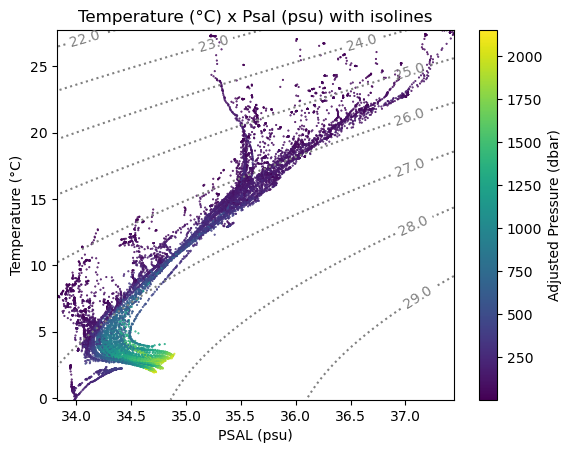

In [243]:
plt.scatter(X, y, c=pres, s=0.25, cmap='viridis')
plt.colorbar(label="Adjusted Pressure (dbar)")

sal_grid = np.linspace(np.min(X), np.max(X), 100) # calculo dos grids 
temp_grid = np.linspace(np.min(y), np.max(y), 100)
SAL, TEMP = np.meshgrid(sal_grid, temp_grid) 


SA_grid = gsw.SA_from_SP(SAL, 0, lon.mean(), lat.mean())
CT_grid = gsw.CT_from_t(SA_grid, TEMP, 0)


sigma_grid = gsw.sigma0(SA_grid, CT_grid)


cs = plt.contour(SAL, TEMP, sigma_grid, levels=np.arange(20, 30, 1), colors='gray', linestyles='dotted') # plot dos grids pras isolinhas
plt.clabel(cs, fmt="%.1f")
plt.title("Temperature (°C) x Psal (psu) with isolines")
plt.xlabel("PSAL (psu)")
plt.ylabel("Temperature (°C)") 

In [244]:
X = X.reshape(-1,1)
y = y.reshape(-1,1)
pres = pres.reshape(-1,1)
lat = lat.reshape(-1,1)
lon = lon.reshape(-1,1) # reshaping

scalerY = StandardScaler()
scalerX = StandardScaler()
scalerPres = StandardScaler()

X = scalerX.fit_transform(X) # normalização
y = scalerY.fit_transform(y)
pres = scalerPres.fit_transform(pres)
lat = np.sin(lat * np.pi/180)
lon = np.sin(lon * np.pi/180)

inVector = np.column_stack((X, lat, lon, pres))

In [294]:
class Model(nn.Module): # criação da classe modelo; herda nn.Module do PyTorch
    def __init__(self, inFeatures = 4, h1 = 512, h2 = 256, h3 = 128, h4 = 64, h5 = 32, outFeatures=1): # (PSAL, LAT, LON, PRES)--> h1 --> h2 --> ... --> TEMP 
        super().__init__() # instanciando nn.Module
        self.fullyConnected1 = nn.Linear(inFeatures, h1) # conexão entre camadas
        self.fullyConnected2 = nn.Linear(h1, h2)
        self.fullyConnected3 = nn.Linear(h2, h3)
        self.fullyConnected4 = nn.Linear(h3, h4)
        self.fullyConnected5 = nn.Linear(h4, h5)
        self.out = nn.Linear(h5, outFeatures)

    def forward(self, x): # forward propagation 
        x = functional.relu(self.fullyConnected1(x)) # função de ativação usada foi a ReLU
        x = functional.relu(self.fullyConnected2(x))
        x = functional.relu(self.fullyConnected3(x))
        x = functional.relu(self.fullyConnected4(x))
        x = functional.relu(self.fullyConnected5(x))
        x = self.out(x)

        return x

In [295]:
class dataset(Dataset):
    def __init__(self, inputs, outputs):
        super().__init__()
        self.inputs = torch.from_numpy(inputs).float()
        self.outputs = torch.from_numpy(outputs).float()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]

In [296]:
model = Model()
torchSet = dataset(inVector, y)

In [297]:
def createDataLoader(batch_size, dataset):
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True, num_workers = 2)

    for batch in dataloader:
        x, y = batch

        print(f"Batch size {x.shape}, labels: {y.shape}")

        break

In [298]:
def kFoldCrossValidation(torchDataArray : Dataset, batchSize : int, nSplits : int, shuffle=True) -> Generator[DataLoader, Dataset, None]: #yielda um DataLoader (iterable) quando enviado um dataset
    kfold = KFold(n_splits = nSplits, shuffle=shuffle) 

    for fold, (train_idx, val_idx) in enumerate(kfold.split(torchDataArray)):

        trainSubset = Subset(torchDataArray, train_idx)
        validationSubset = Subset(torchDataArray, val_idx)

        trainLoader = DataLoader(trainSubset, batch_size = batchSize, num_workers = 2) # iterable
        validationLoader = DataLoader(validationSubset, batch_size = batchSize, shuffle=False, num_workers = 2)

        yield trainLoader, validationLoader, trainSubset, validationSubset


In [299]:
def kFoldTrain(model: Model, epochs: int, lossFunction, optim, generatorObject) -> tuple[list[np.float32], list[np.float32]]:
    train_losses = []  # Average training loss per epoch
    val_losses = []    # Average validation loss per epoch
    
    best_val_loss = float('inf')
    patience = 10
    
    for fold, (train_loader, val_loader, _, _) in enumerate(generatorObject):
        epochs_no_improve = 0
        print("---------------------------------------------------------------")
        print(f"Fold: {fold + 1}")
        
        for epoch in range(epochs):
            counter = 0
            # Training phase
            model.train()
            epoch_train_losses = []
            
            for batch in train_loader:
                inputs, targets = batch
                
                optim.zero_grad()
                outputs = model(inputs)
                loss = lossFunction(outputs, targets)
                loss.backward()
                optim.step()
                epoch_train_losses.append(loss.item())
                
                counter += 1
            print(f"Epoch: {epoch} \t Batches: {counter} \t Loss: {loss}")
            # Validation phase
            model.eval()
            epoch_val_losses = []
            with torch.no_grad():
                for batch in val_loader:
                    inputs, targets = batch
                    outputs = model(inputs)
                    loss = lossFunction(outputs, targets)
                    epoch_val_losses.append(loss.item())
            # Store average losses for this epoch
            avg_train_loss = np.mean(epoch_train_losses)
            avg_val_loss = np.mean(epoch_val_losses)
            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)
            
            if loss.item() < best_val_loss:
                best_val_loss = loss.item()
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            if epochs_no_improve == patience:
                print("Early stopping!")
                break
            
            
    
    return train_losses, val_losses

In [300]:
lossCriterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [301]:
generatorObj = kFoldCrossValidation(torchSet, 2048, 10)
lossListPlot, valLossListPlot = kFoldTrain(model, numEpochs, lossCriterion, optimizer,generatorObj)

---------------------------------------------------------------
Fold: 1
Epoch: 0 	 Batches: 6 	 Loss: 1.0286564826965332
Epoch: 1 	 Batches: 6 	 Loss: 0.6517630815505981
Epoch: 2 	 Batches: 6 	 Loss: 0.13693110644817352
Epoch: 3 	 Batches: 6 	 Loss: 0.13171900808811188
Epoch: 4 	 Batches: 6 	 Loss: 0.08163571357727051
Epoch: 5 	 Batches: 6 	 Loss: 0.055225346237421036
Epoch: 6 	 Batches: 6 	 Loss: 0.060068413615226746
Epoch: 7 	 Batches: 6 	 Loss: 0.05739416927099228
Epoch: 8 	 Batches: 6 	 Loss: 0.04200906306505203
Epoch: 9 	 Batches: 6 	 Loss: 0.04472337290644646
Epoch: 10 	 Batches: 6 	 Loss: 0.03975973650813103
Epoch: 11 	 Batches: 6 	 Loss: 0.04053733870387077
Epoch: 12 	 Batches: 6 	 Loss: 0.04053323343396187
Epoch: 13 	 Batches: 6 	 Loss: 0.04135030508041382
Epoch: 14 	 Batches: 6 	 Loss: 0.040244631469249725
Epoch: 15 	 Batches: 6 	 Loss: 0.04058847948908806
Epoch: 16 	 Batches: 6 	 Loss: 0.040161941200494766
Epoch: 17 	 Batches: 6 	 Loss: 0.04070195183157921
Epoch: 18 	 Batche

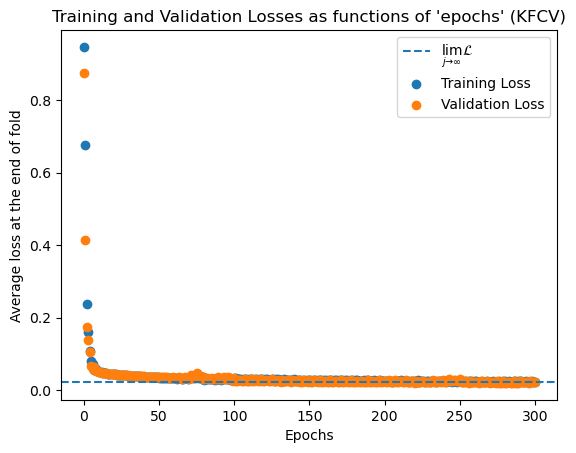

In [337]:
plt.title("Training and Validation Losses as functions of 'epochs' (KFCV)")
plt.scatter(np.arange(0, len(lossListPlot)),lossListPlot)
plt.xlabel("Epochs")
plt.ylabel("Average loss at the end of fold")
plt.scatter(np.arange(0, len(valLossListPlot)),valLossListPlot)
plt.axhline(valLossListPlot[-1], ls= '--')
plt.legend(("$\lim_{j → \infty}\mathcal{L}$", "Training Loss", "Validation Loss"))

In [303]:
with torch.no_grad():
    outs = model(torch.tensor(inVector))
    outs = scalerY.inverse_transform(outs.numpy())

In [304]:
yNonNormalized = scalerX.inverse_transform(y_og.reshape(-1,1))

In [305]:
torch.Tensor.ndim = property(lambda self: len(self.shape))

In [306]:
invVec =  np.column_stack((scalerX.inverse_transform(X), np.arcsin(lat)*180/(np.pi), np.arcsin(lon)*180/(np.pi), scalerPres.inverse_transform(pres))) # isso aqui é completamente desnecessário... essas inversas são só os dados originais

In [307]:
X_og =  np.array([x[0] for x in dataArr], dtype=np.float32)  # shape (N, 1)
y_og = np.array([x[4] for x in dataArr], dtype=np.float32)
pres_og = np.array([x[3] for x in dataArr], dtype=np.float32)
lat_vec = np.array([x[1] for x in invVec], dtype=np.float32)
lon_vec = np.array([x[2] for x in invVec], dtype=np.float32)

Text(0, 0.5, 'Temperature (°C)')

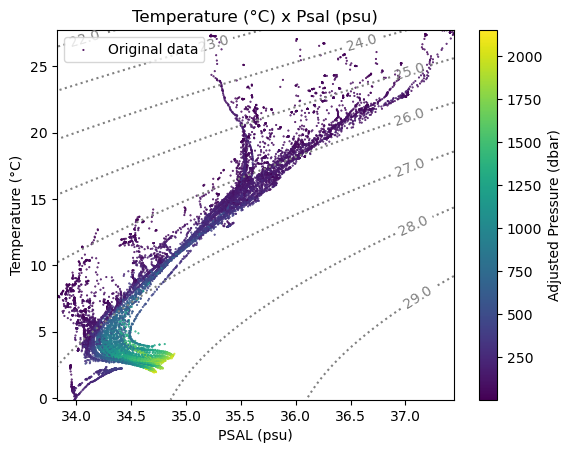

In [308]:
plt.scatter(X_og, y_og, c=pres_og,s=0.25, cmap="viridis")
plt.colorbar(label="Adjusted Pressure (dbar)")
sal_grid = np.linspace(np.min(X_og), np.max(X_og), 100)
temp_grid = np.linspace(np.min(y_og), np.max(y_og), 100)
SAL, TEMP = np.meshgrid(sal_grid, temp_grid)

# SA, CT
SA_grid = gsw.SA_from_SP(SAL, 0, lon_vec.mean(), lat_vec.mean())
CT_grid = gsw.CT_from_t(SA_grid, TEMP, 0)

# densidade potencial sigma0
sigma_grid = gsw.sigma0(SA_grid, CT_grid)

# plot contornos
cs = plt.contour(SAL, TEMP, sigma_grid, levels=np.arange(20, 30, 1), colors='gray', linestyles='dotted')
plt.clabel(cs, fmt="%.1f")
plt.title("Temperature (°C) x Psal (psu)")
plt.legend(("Original data", "Estimation"))
plt.xlabel("PSAL (psu)")
plt.ylabel("Temperature (°C)")

Text(0, 0.5, 'Temperature (°C)')

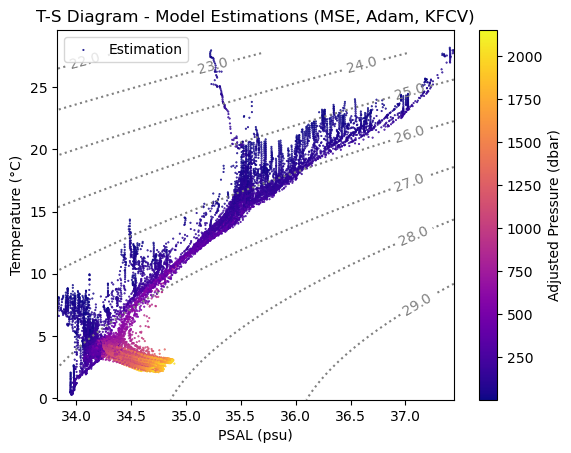

In [341]:
plt.scatter(X_og, outs, c=pres_og,s=0.25, cmap="plasma")
plt.colorbar(label="Adjusted Pressure (dbar)")
sal_grid = np.linspace(np.min(X_og), np.max(X_og), 100)
temp_grid = np.linspace(np.min(y_og), np.max(y_og), 100)
SAL, TEMP = np.meshgrid(sal_grid, temp_grid)

# SA, CT
SA_grid = gsw.SA_from_SP(SAL, 0, lon_vec.mean(), lat_vec.mean())
CT_grid = gsw.CT_from_t(SA_grid, TEMP, 0)

# densidade potencial sigma0
sigma_grid = gsw.sigma0(SA_grid, CT_grid)

# plot contornos
cs = plt.contour(SAL, TEMP, sigma_grid, levels=np.arange(20, 30, 1), colors='gray', linestyles='dotted')
plt.clabel(cs, fmt="%.1f")
plt.title("T-S Diagram - Model Estimations (MSE, Adam, KFCV)")
plt.legend(("Estimation", "_"))
plt.xlabel("PSAL (psu)")
plt.ylabel("Temperature (°C)")

In [338]:
def resRed(yArr, o):
    yArr = yArr.flatten()
    o = o.flatten()
    min_len = min(len(yArr), len(o))

    yArr = yArr[:min_len]
    o = o[:min_len]

    res = yArr - o
    plt.title("Residual analysis for the model")
    plt.scatter(o, res)
    plt.axhline(0, color='r', ls='--')
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")

    return 0

0

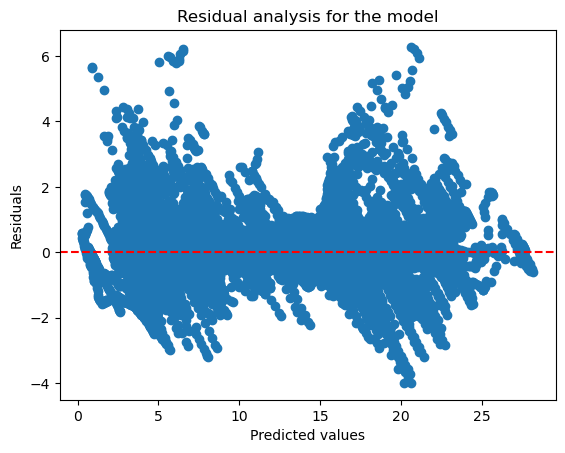

In [339]:
resRed(y_og, outs)